In [20]:
import pandas as pd 
import numpy as np
import re
pd.options.mode.chained_assignment = None  # default='warn'

In [21]:
df = pd.read_csv("https://raw.githubusercontent.com/slavaspirin/Toronto-housing-price-prediction/master/houses.csv")
original_data = df.copy()
df.head()

,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code
0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2 baths,800–899 sq. ft.,1 parking,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76
1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14
2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1 beds,1 baths,500–599 sq. ft.,no parking,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104
3,3,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,1 + 1 beds,1 baths,600–699 sq. ft.,1 parking,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82
4,4,"61 Twelfth St, Toronto (W4519375) | Zoocasa",825513,839000,2 beds,2 baths,N/A sq. ft.,1 parking,Location! Location! Location. Your Cottage In ...,W4519375,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"61 Twelfth St, Toronto , Ontario, Canada",43.597096,-79.509612,New Toronto,44101,18


In [22]:
def cleansing_function(df):
    df = df.copy()
    abnType = df['type'].unique()[5] ## taking out the abnormal hosue type
    df = df[df['type']!= abnType]
    ## checking all the cities that are in the data

    '''
    we are going to split the data using the "," and then split based on teh space and get the city from each one,

    This will be added to a new column called "city"
    '''
    df["city"] = df["full_address"].apply(lambda x: x.split(",")[1].split(" ")[1].upper())
    ## now we will exclude the only row with the value "OUT" as city

    df = df[df["city"] != "OUT"]
    ## now let's clean the bedrooms column

    df["bedrooms"] = df["bedrooms"].apply(lambda x: ' '.join(x.split(" ")))

    for i,n in enumerate(df["bedrooms"]):
        df["bedrooms"].iloc[i] = max([int(s) for s in n.split() if s.isdigit()])
    ## now let's clean the bathrooms column

    df["bathrooms"] = df["bathrooms"].apply(lambda x: int(''.join(x.lower()).replace("baths", '')))
    ## now let's clean the parking column
    df["parking"] = df["parking"].apply(lambda x:    str(x).replace('no parking', '0')  )
    df["parking"] = df["parking"].apply(lambda x:    int(str(x).replace(' parking', '')  ))
    
    ## cleaning the type column

    df["type"] = df["type"].str.upper()

    for i,t in enumerate(df["type"]):
        if "APT" in t:
            df["type"].iloc[i] = "APT"
        elif "CONDO" in t:
            df["type"].iloc[i] = "CONDO"
        elif "DETACHED" in t:
            df["type"].iloc[i] = "DETACHED_HOUSE"
        elif "TWNHOUSE" in t:
            df["type"].iloc[i] = "TWNHOUSE"
    df["type"] = df["type"][df["type"] != "COTTAGE"][df["type"] != "FOURPLEX"]
    
    ## counting out rows that have bathrooms more than bedrooms
    df = df.query("bedrooms >= bathrooms")
    return df


In [23]:
df = cleansing_function(df)
df.shape

(13310, 19)

In [24]:
## fearures that will be used in this machine learing model, along with our target will be to find the final_price :

df[["bedrooms", "bathrooms", "parking", "long", "lat", "final_price"]]

,bedrooms,bathrooms,parking,long,lat,final_price
0,2,2,1,-79.385748,43.661896,855000
1,3,2,6,-79.530356,43.646982,885000
2,1,1,0,-79.397498,43.708472,550000
3,1,1,1,-79.414448,43.638399,665000
4,2,2,1,-79.509612,43.597096,825513
...,...,...,...,...,...,...
15231,2,2,1,-79.393065,43.648317,785000
15232,5,5,2,-79.262789,43.706338,1025000
15233,3,3,1,-79.160342,43.788258,681000
15234,1,1,0,-79.378756,43.660846,590000


In [25]:
## our target
y = df.final_price

In [26]:
data_features = ["bedrooms", "bathrooms", "parking", "long", "lat"]

In [27]:
## features
X = df[data_features]

In [28]:
X.describe().round(decimals=2)

,bathrooms,parking,long,lat
count,13310.00,13310.00,13310.00,13310.00
mean,1.92,1.61,-79.39,43.70
std,0.87,5.30,0.10,0.06
min,1.00,0.00,-79.62,43.59
25%,1.00,1.00,-79.46,43.65
50%,2.00,1.00,-79.40,43.69
75%,2.00,2.00,-79.33,43.76
max,9.00,367.00,-79.12,43.84


In [29]:
X.isna().sum()

bedrooms     0
bathrooms    0
parking      0
long         0
lat          0
dtype: int64

In [30]:
X.head()

,bedrooms,bathrooms,parking,long,lat
0,2,2,1,-79.385748,43.661896
1,3,2,6,-79.530356,43.646982
2,1,1,0,-79.397498,43.708472
3,1,1,1,-79.414448,43.638399
4,2,2,1,-79.509612,43.597096


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.20, random_state = 0)
print(train_X.shape)
print(val_X.shape)
print(train_y.shape)
print(val_y.shape)
# Define model
DT_model = DecisionTreeRegressor()
# Fit model
DT_model.fit(train_X, train_y)

# get predicted prices on validation data
val_predictions = DT_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

(10648, 5)
(2662, 5)
(10648,)
(2662,)
132624.90972933342


In [32]:
# print the top few validation predictions
print(val_predictions[0:5])
# print the top few actual prices from validation data
print(val_y.head())

[1675000.  389000.  305000.  706000. 1055000.]
6347     1175000
7419      430000
11293     305000
6334      600000
5622     1049000
Name: final_price, dtype: int64


In [33]:
## performance of the model. Give the R2 score

from sklearn.metrics import r2_score

r2_score(val_y, val_predictions)

0.6906169760582372

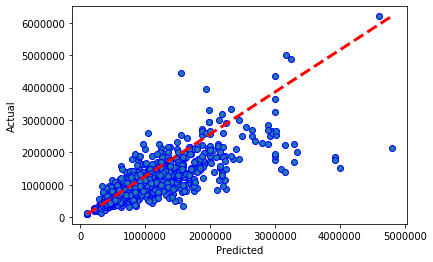

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(val_predictions, val_y, edgecolors=(0, 0, 1))
ax.plot([val_predictions.min(), val_predictions.max()], [val_y.min(), val_y.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()